# Training RNN to Create Both a Circle and a Figure Eight (Multi-Attractor)

This notebook uses a basic Elman network (see `elman.py`) to generate either a circle or a figure eight depending on the location of the initial point. The circle and figure eight data is the same as in the other example notebooks, and was generated by drawing the approximate shapes using [OIST CNRU's mouse_drawing_app](https://github.com/oist-cnru/mouse_drawing_app).

In [83]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 120

# Seed so we have reproducible results
# (since we randomly generate the initial weights)
np.random.seed(0)

# Progress bar
import tqdm
import colour
from PIL import Image

# For training and evaluating large data sets, it is recommended to 
# use elman_opt: this file is compiled in C using numba and is ~5x
# faster (on average) than the pure python version
#from elman import ElmanNetwork, normalize, save, load
from elman_opt import ElmanNetwork, normalize, save, load

We'll arbitrarily put the circle in the bottom left, and the figure eight in the top right. Probably any other configuration would work too, but we just want to make sure they are reasonably well separated.

At the bottom of this notebook, I have another example in which the figure eight sits inside of the circle, though this is a little more difficult to achieve.

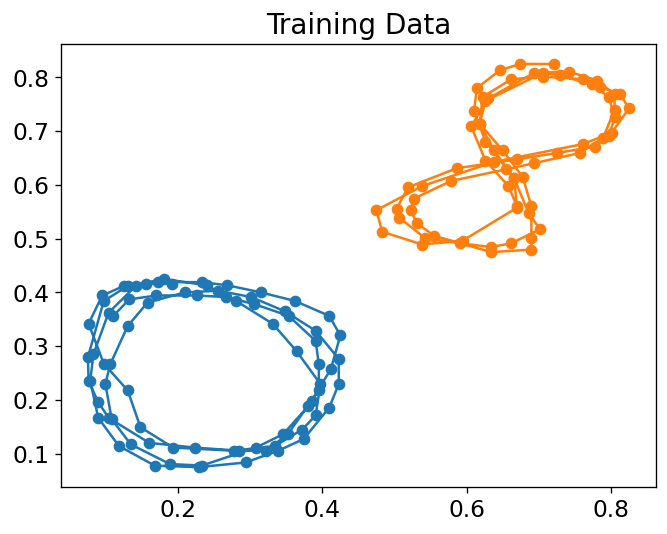

In [46]:
circleData = np.genfromtxt('data/mouse_circle_data.csv', delimiter=',')
figureEightData = np.genfromtxt('data/mouse_figure_eight_data.csv', delimiter=',')

dsFactor = 4

# Put circle into bottom left
circleXArr = normalize(circleData[::dsFactor,0]) / 2
circleYArr = normalize(circleData[::dsFactor,1]) / 2

# Put figure eight into top right

feXArr = normalize(figureEightData[::dsFactor,0]) / 2 + .4
feYArr = normalize(figureEightData[::dsFactor,1]) / 2 + .4

plt.plot(circleXArr, circleYArr, '-o')
plt.plot(feXArr, feYArr, '-o')
plt.title('Training Data')
plt.show()

## Load Model

If you've already trained a model, you can load it in from here. Note that the learning curve will not be saved, so this will be empty.

In [34]:
numEpochs = 100000

model = load('models/multi_attractor.npz')

circleInputArr = np.array(list(zip(circleXArr, circleYArr)))[:-1]
circleTargetArr = np.array(list(zip(circleXArr, circleYArr)))[1:]

feInputArr = np.array(list(zip(feXArr, feYArr)))[:-1]
feTargetArr = np.array(list(zip(feXArr, feYArr)))[1:]

# So we can easily index both input and target arrays
inputArr = [circleInputArr, feInputArr]
targetArr = [circleTargetArr, feTargetArr]

errorArr = np.ones(numEpochs) # list to store errors

## Train Model

This will train the model from scratch, for the set number of epochs and network hyperparameters.

Note that in comparison to the previous examples, we need quite a bit more training epochs to get good results.

Another important point is that we are of course training on two different data sets, so there is the freedom to choose how much of each we should train on. The circle is simpler, but if we bias too heavily towards the figure eight, we will disproportionately generate that shape. On top of this, we don't want to train on the figure eight for 10000 epochs, and then the circle for 10000 epochs, since then the output will almost always be circle since that was trained last. To avoid this, we order the training randomly, so that we should be able to reproduce both shapes at any given time.

Lastly, since we are doing quite a few epochs, we want to avoid overfitting by adding a little bit of noise to the training data each time. Specifically, this is sampled from a normal distribution and is on the order of $\approx 1-5\%$.

In [60]:
# Quite a few epochs
numEpochs = 30000
# What percent of the epochs should train the circle?
circleFigureEightTrainingSplit = .4 # .2 means 20% circle, 80% figure eight
# How strong should the noise be that we add to the training data each epoch?
# This value is the width of the gaussian that the noise is sampled from
# (centered at 0).
noiseStrength = .05

# 30 hidden neurons seems fine for this
model = ElmanNetwork(inputDim=2,
                     contextDim=30,
                     outputDim=2,
                     learningRate=.1)

circleInputArr = np.array(list(zip(circleXArr, circleYArr)))[:-1]
circleTargetArr = np.array(list(zip(circleXArr, circleYArr)))[1:]

feInputArr = np.array(list(zip(feXArr, feYArr)))[:-1]
feTargetArr = np.array(list(zip(feXArr, feYArr)))[1:]

# So we can easily index both input and target arrays
inputArr = [circleInputArr, feInputArr]
targetArr = [circleTargetArr, feTargetArr]

errorArr = np.zeros(numEpochs) # list to store errors

# Mix up the order in which we train each shape
trainingOrder = [0]*int(np.floor(numEpochs*circleFigureEightTrainingSplit)) + [1]*int(np.floor(numEpochs*(1 - circleFigureEightTrainingSplit)))
np.random.shuffle(trainingOrder)

# In case rounding to integers has caused us to lose an element, we add it back
if len(trainingOrder) < numEpochs:
    trainingOrder += [0]* (numEpochs - len(trainingOrder))

for epoch in tqdm.tqdm(range(numEpochs)):
    # Context and output
    noiseArr = np.random.normal(0, noiseStrength, size=inputArr[trainingOrder[epoch]].shape)
    
    contextArr, outputArr = model.forwardSequence(inputArr[trainingOrder[epoch]] + noiseArr)
    errorArr[epoch]  = model.backwardSequence(inputArr[trainingOrder[epoch]] + noiseArr,
                                              contextArr, outputArr, targetArr[trainingOrder[epoch]])
    model.updateParameters()
    
save(model, 'models/multi_attractor.npz')

100%|███████████████████████████████████████████████████| 30000/30000 [00:13<00:00, 2170.69it/s]


Examine the results of the training, including the learning curve, and how well the network recreates both shapes.

The learning curve for this one will look slightly different than the other networks, since it is actually a superposition of two learning curves, one for each shape.

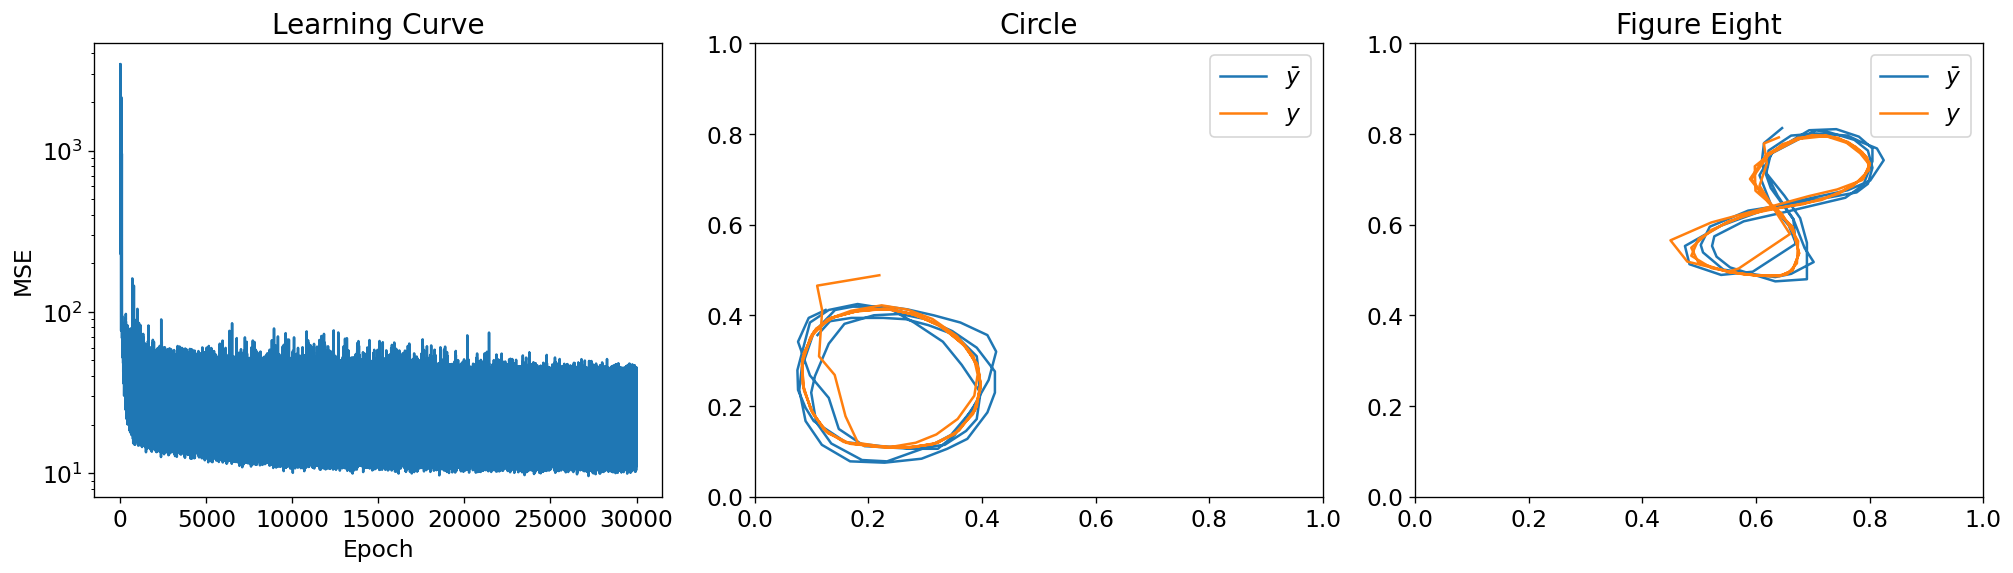

In [61]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

circleOutputArr = model.predict([circleXArr[0], circleYArr[1]], circleXArr.shape[0])

ax[1].plot(targetArr[0][1:,0], targetArr[0][1:,1], label=r'$\bar y$')
ax[1].plot(circleOutputArr[1:,0], circleOutputArr[1:,1], label=r'$y$')
ax[1].legend()
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].set_title('Circle')

ax[2] = fig.add_subplot(1, 3, 3)

feOutputArr = model.predict([feXArr[0], feYArr[1]], feXArr.shape[0])

ax[2].plot(targetArr[1][1:,0], targetArr[1][1:,1], label=r'$\bar y$')
ax[2].plot(feOutputArr[1:,0], feOutputArr[1:,1], label=r'$y$')
ax[2].legend()
ax[2].set_xlim([0,1])
ax[2].set_ylim([0,1])
ax[2].set_title('Figure Eight')

fig.tight_layout()

#plt.savefig('images/multi_attractor_learning_curve.png')
plt.show()

## Phase Diagram

For which initial points do we generate a circle, and for which do we generate a figure eight? First, we can example a few tests to make sure that generally points on the left make a circle, and points on the right make a figure eight.

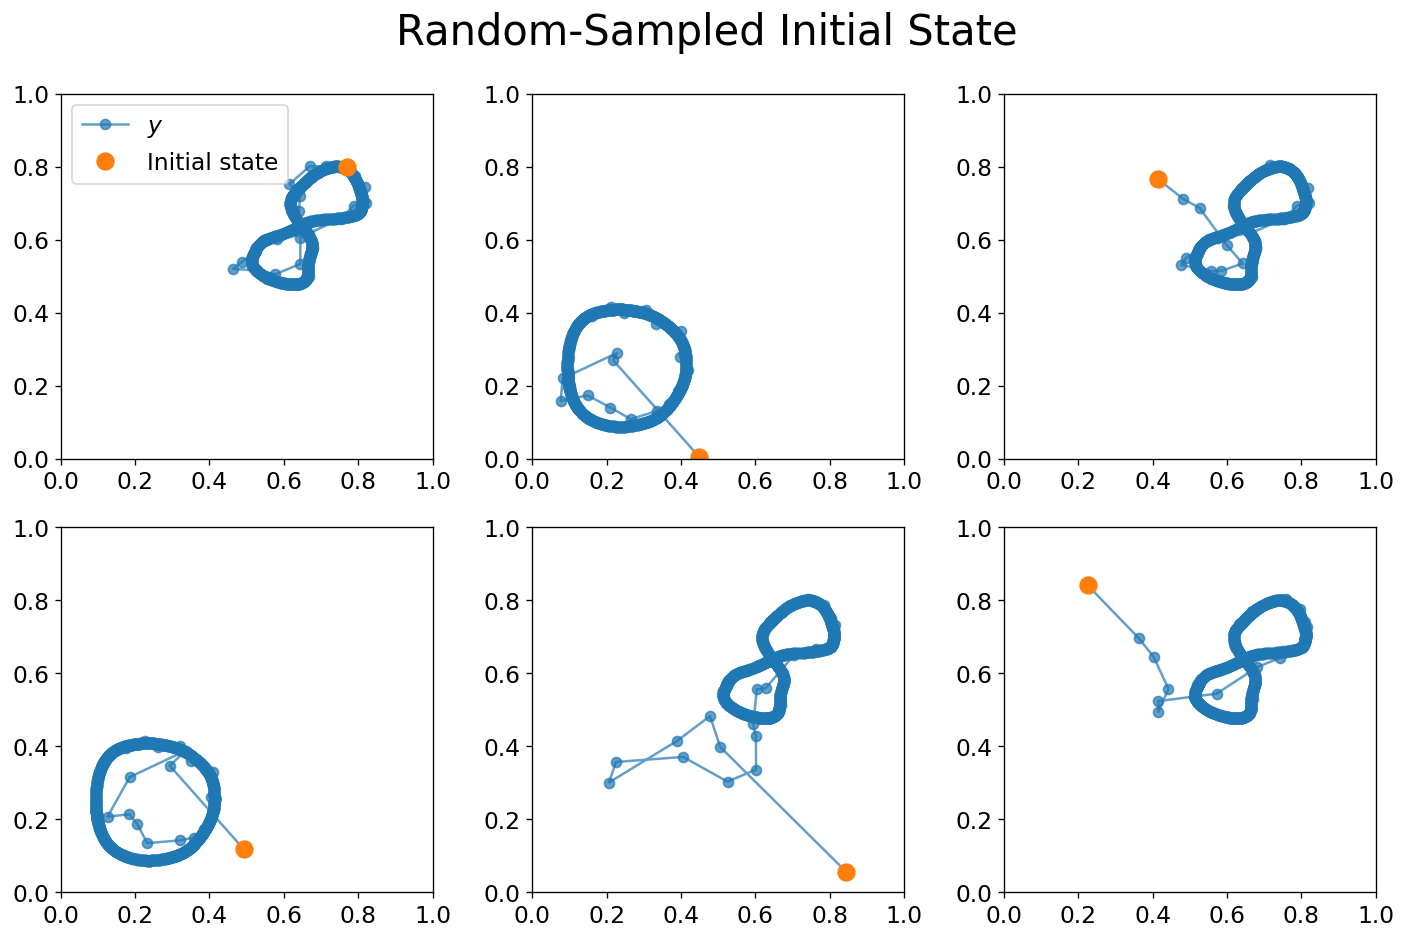

In [49]:
initialPoints = np.random.uniform(0, 1, size=(6,2))
#initialPoints = [[1, .2], [.5, .5]]

fig, ax = plt.subplots(2, len(initialPoints) // 2, figsize=(len(initialPoints)*2,8))

for i in range(len(initialPoints)):

    nSteps = 1000

    predictArr = model.predict(initialPoints[i], nSteps)
    
    ax[i//len(ax[0]),i%len(ax[0])].plot(predictArr[:,0], predictArr[:,1], '-o', alpha=.7, label='$ y $')
    ax[i//len(ax[0]),i%len(ax[0])].plot(initialPoints[i][0], initialPoints[i][1], 'o', markersize=10, label='Initial state')

    ax[i//len(ax[0]),i%len(ax[0])].set_xlim([0, 1])
    ax[i//len(ax[0]),i%len(ax[0])].set_ylim([0, 1])

ax[0,0].legend()
fig.suptitle('Random-Sampled Initial State', fontsize=25)
fig.tight_layout()
#plt.savefig('images/multi_attractor_initial_test.png')
plt.show()

Now let's actually make a proper phase plot by sample a grid of points across our phase space and seeing which shape they make.

We can easily tell which shape we have by just averaging the position of the points after the shape has reached steady state behavior: if it is close to $[.25, .25]$ we have a circle, and if it is close to $[.7, .7]$ we have a figure eight.

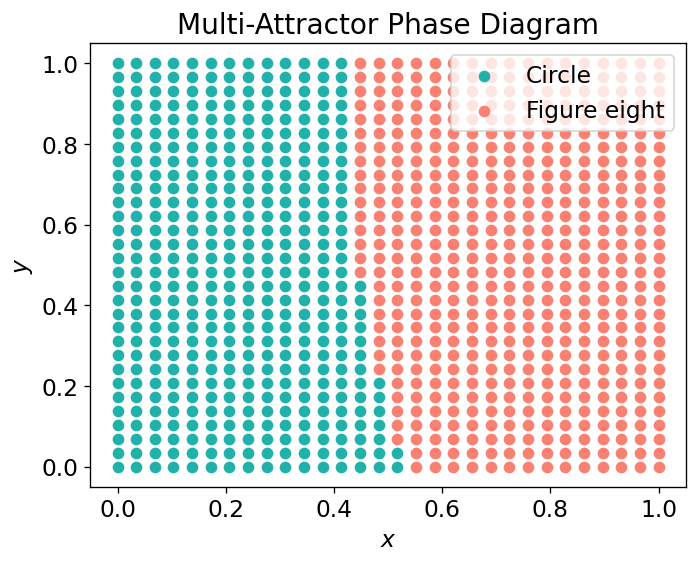

Ratio of area in phase diagram: circle/total = 0.459
Ratio of area in phase diagram: figure eight/total = 0.541


In [62]:
testXArr = np.linspace(0, 1, 30)
testYArr = np.linspace(0, 1, 30)
nSteps = 500

phaseArr = np.zeros((len(testXArr), len(testYArr)))

predictArr = np.zeros((len(testXArr), len(testYArr), nSteps+1, 2))

for i in range(len(testXArr)):
    for j in range(len(testYArr)):

        predictArr[i,j] = model.predict([testXArr[i], testYArr[j]], nSteps)
        
        # Take average of last 100
        averagePosition = np.mean(predictArr[i,j,-100:], axis=0)
        
        # If average position is around .25, .25, then it is a circle (0)
        # If average position is around .75, .75, then it is a figure eight (1)
        # Otherwise, something weird happened (2)
        if np.sqrt(np.sum((averagePosition - np.array([.25, .25]))**2)) < .2:
            phaseArr[i,j] = 0
        elif np.sqrt(np.sum((averagePosition - np.array([.7, .7]))**2)) < .2:
            phaseArr[i,j] = 1
        else:
            phaseArr[i,j] = 2
            
plt.scatter(testXArr[np.where(phaseArr == 0)[0]], testYArr[np.where(phaseArr == 0)[1]], c='lightseagreen', label='Circle')
plt.scatter(testXArr[np.where(phaseArr == 1)[0]], testYArr[np.where(phaseArr == 1)[1]], c='salmon', label='Figure eight')
#plt.scatter(testXArr[np.where(phaseArr == 2)[0]], testYArr[np.where(phaseArr == 2)[1]], c='slategray', label='Non-convergent')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Multi-Attractor Phase Diagram')
#plt.savefig('images/multi_attractor_phase_diagram.png')
plt.show()

values, counts = np.unique(phaseArr, return_counts=True)
print(f'Ratio of area in phase diagram: circle/total = {counts[values == 0][0] / np.sum(counts):.3}')
print(f'Ratio of area in phase diagram: figure eight/total = {counts[values == 1][0] / np.sum(counts):.3}')

This plot can vary from training to training, but generally looks pretty good!

We can see that there is some slight bias towards creating a figure eight, but that is expected since we have trained on that shape for a larger number of epochs.

Below, we can try to quantify this bias as a function of the training split parameter, but first, let's make a nice animation that includes information about each trajectory.

## Animated Trajectory

In [103]:
colorArr = colour.Color('Red').range_to(colour.Color('Blue'), len(testXArr)*len(testYArr))
colorArr = [str(c) for c in colorArr]

colorArr = colorArr[:-2:3] + colorArr[1:-1:3] + colorArr[2::3]

numFrames = 50
startFrames = 30
trailingPoints = 5

images = [None]*(numFrames+startFrames)

    
for j in range(len(testXArr)):
    for k in range(len(testYArr)):
        plt.plot(predictArr[j,k,0,0], predictArr[j,k,0,1], '-o', alpha=.8, c=colorArr[len(testYArr)*j+k])

canvas = plt.get_current_fig_manager().canvas
canvas.draw()

startImage = Image.frombytes('RGB', canvas.get_width_height(), 
             canvas.tostring_rgb())

plt.close()

for i in range(startFrames):#nSteps+1):
    images[i] = startImage

for i in tqdm.tqdm(range(numFrames)):#nSteps+1):
    
    for j in range(len(testXArr)):
        for k in range(len(testYArr)):
            plt.plot(predictArr[j,k,max(i-trailingPoints,0):i,0], predictArr[j,k,max(i-trailingPoints,0):i,1], '-o', alpha=.08, c=colorArr[len(testYArr)*j+k])
            plt.plot(predictArr[j,k,i,0], predictArr[j,k,i,1], '-o', alpha=.8, c=colorArr[len(testYArr)*j+k])
    
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()

    images[i+startFrames] = Image.frombytes('RGB', canvas.get_width_height(), 
                 canvas.tostring_rgb())
    #plt.show()
    plt.close()

images[0].save('images/multi_attractor_trajectory.gif', save_all=True, append_images=images[1:], duration=.5, loop=0)

100%|███████████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it]


## Attractor Bias Based on Training Split

In [54]:
numEpochs = 40000
numTestSplits = 10
# eg. .2 means 20% circle, 80% figure eight
circleFigureEightTrainingSplitArr = np.linspace(0.1, .9, numTestSplits)
noiseStrength = .01

statisticRepeat = 5
biasArr = np.zeros((numTestSplits, statisticRepeat))

circleInputArr = np.array(list(zip(circleXArr, circleYArr)))[:-1]
circleTargetArr = np.array(list(zip(circleXArr, circleYArr)))[1:]

feInputArr = np.array(list(zip(feXArr, feYArr)))[:-1]
feTargetArr = np.array(list(zip(feXArr, feYArr)))[1:]

inputArr = [circleInputArr, feInputArr]
targetArr = [circleTargetArr, feTargetArr]

for i in tqdm.tqdm(range(numTestSplits), position=0):
    for l in range(statisticRepeat):
        split = circleFigureEightTrainingSplitArr[i]

        model = ElmanNetwork(inputDim=2,
                             contextDim=30,
                             outputDim=2,
                             learningRate=.1)

        errorArr = np.zeros(numEpochs) # list to store errors

        # Ceil and floor to make sure the sum is always equal to numEpochs exactly
        trainingOrder = [0]*int(np.ceil(numEpochs*split)) + [1]*int(np.floor(numEpochs*(1 - split)))
        if len(trainingOrder) < numEpochs:
            trainingOrder += [0]* (numEpochs - len(trainingOrder))

        np.random.shuffle(trainingOrder)

        for epoch in range(numEpochs):
            # Generate some random noise to add to the input
            noiseArr = np.random.normal(0, noiseStrength, size=inputArr[trainingOrder[epoch]].shape)

            # Context and output
            contextArr, outputArr = model.forwardSequence(inputArr[trainingOrder[epoch]] + noiseArr)
            errorArr[epoch]  = model.backwardSequence(inputArr[trainingOrder[epoch]] + noiseArr,
                                                      contextArr, outputArr, targetArr[trainingOrder[epoch]])
            model.updateParameters()

        save(model, f'models/multi_attractor_{split:.2}_split.npz')

        testXArr = np.linspace(0, 1, 30)
        testYArr = np.linspace(0, 1, 30)
        nSteps = 500

        phaseArr = np.zeros((len(testXArr), len(testYArr)))

        for j in range(len(testXArr)):
            for k in range(len(testYArr)):

                predictArr = model.predict([testXArr[j], testYArr[k]], nSteps)

                # Take average of last 100
                averagePosition = np.mean(predictArr[-100:], axis=0)

                # If average position is around .25, .25, then it is a circle (0)
                # If average position is around .75, .75, then it is a figure eight (1)
                # Otherwise, something weird happened (2)
                if np.sqrt(np.sum((averagePosition - np.array([.25, .25]))**2)) < .15:
                    phaseArr[j,k] = 0
                elif np.sqrt(np.sum((averagePosition - np.array([.75, .75]))**2)) < .15:
                    phaseArr[j,k] = 1
                else:
                    phaseArr[j,k] = 2

        values, counts = np.unique(phaseArr, return_counts=True)

        biasArr[i,l] = counts[values == 0][0] / np.sum(counts) if len(counts[values == 0]) > 0 else 0

100%|███████████████████████████████████████████████████████████| 10/10 [16:05<00:00, 96.52s/it]


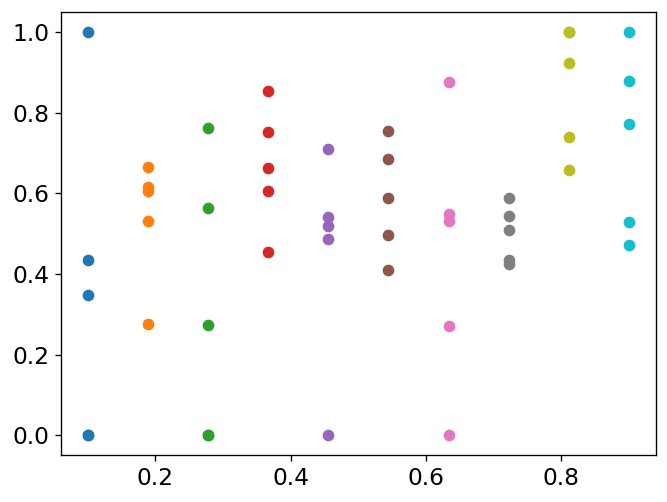

In [55]:
#plt.errorbar(circleFigureEightTrainingSplitArr, np.mean(biasArr, axis=-1), yerr=np.std(biasArr, axis=-1))
for i in range(numTestSplits):
    plt.plot(np.repeat(circleFigureEightTrainingSplitArr[i], statisticRepeat), biasArr[i], 'o')
plt.show()

# Inscribed Figure Eight

Now, let's try to do the same process except with the figure eight located inside the circle. This will be a little more subtle, but it should be possible.

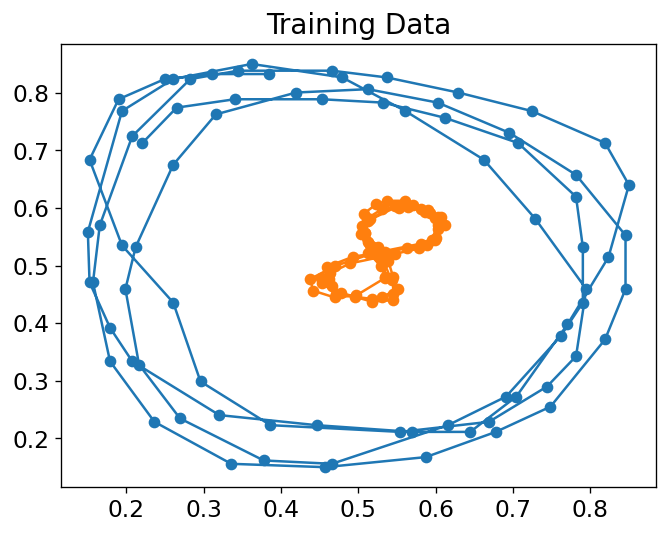

In [138]:
circleData = np.genfromtxt('data/mouse_circle_data.csv', delimiter=',')
figureEightData = np.genfromtxt('data/mouse_figure_eight_data.csv', delimiter=',')

dsFactor = 4

# Put circle outside
circleXArr = normalize(circleData[::dsFactor,0])
circleYArr = normalize(circleData[::dsFactor,1])

# Put figure eight inside
feXArr = normalize(figureEightData[::dsFactor,0]) / 4 + .4
feYArr = normalize(figureEightData[::dsFactor,1]) / 4 + .4

plt.plot(circleXArr, circleYArr, '-o')
plt.plot(feXArr, feYArr, '-o')
plt.title('Training Data')
plt.show()

## Train Model

In [147]:
# Quite a few epochs
numEpochs = 2000000
# What percent of the epochs should train the circle?
circleFigureEightTrainingSplit = .5 # .2 means 20% circle, 80% figure eight
# How strong should the noise be that we add to the training data each epoch?
# This value is the width of the gaussian that the noise is sampled from
# (centered at 0).
noiseStrength = .01

# 30 hidden neurons seems fine for this
model = ElmanNetwork(inputDim=2,
                     contextDim=35,
                     outputDim=2,
                     learningRate=.005)

circleInputArr = np.array(list(zip(circleXArr, circleYArr)))[:-1]
circleTargetArr = np.array(list(zip(circleXArr, circleYArr)))[1:]

feInputArr = np.array(list(zip(feXArr, feYArr)))[:-1]
feTargetArr = np.array(list(zip(feXArr, feYArr)))[1:]

# So we can easily index both input and target arrays
inputArr = [circleInputArr, feInputArr]
targetArr = [circleTargetArr, feTargetArr]

errorArr = np.zeros(numEpochs) # list to store errors

# Mix up the order in which we train each shape
trainingOrder = [0]*int(np.floor(numEpochs*circleFigureEightTrainingSplit)) + [1]*int(np.floor(numEpochs*(1 - circleFigureEightTrainingSplit)))
np.random.shuffle(trainingOrder)

# In case rounding to integers has caused us to lose an element, we add it back
if len(trainingOrder) < numEpochs:
    trainingOrder += [0]* (numEpochs - len(trainingOrder))

for epoch in tqdm.tqdm(range(numEpochs)):
    # Context and output
    randomStart = int(np.random.uniform(0,20)) if trainingOrder[epoch] == 0 else 0
    noiseArr = np.random.normal(0, noiseStrength, size=inputArr[trainingOrder[epoch]].shape - np.array([randomStart,0]))
    
    contextArr, outputArr = model.forwardSequence(inputArr[trainingOrder[epoch]][randomStart:] + noiseArr)
    errorArr[epoch]  = model.backwardSequence(inputArr[trainingOrder[epoch]][randomStart:] + noiseArr,
                                              contextArr, outputArr, targetArr[trainingOrder[epoch]][randomStart:])
    model.updateParameters()
    
save(model, 'models/inscribed_multi_attractor.npz')

100%|███████████████████████████████████████████████| 2000000/2000000 [17:53<00:00, 1863.52it/s]


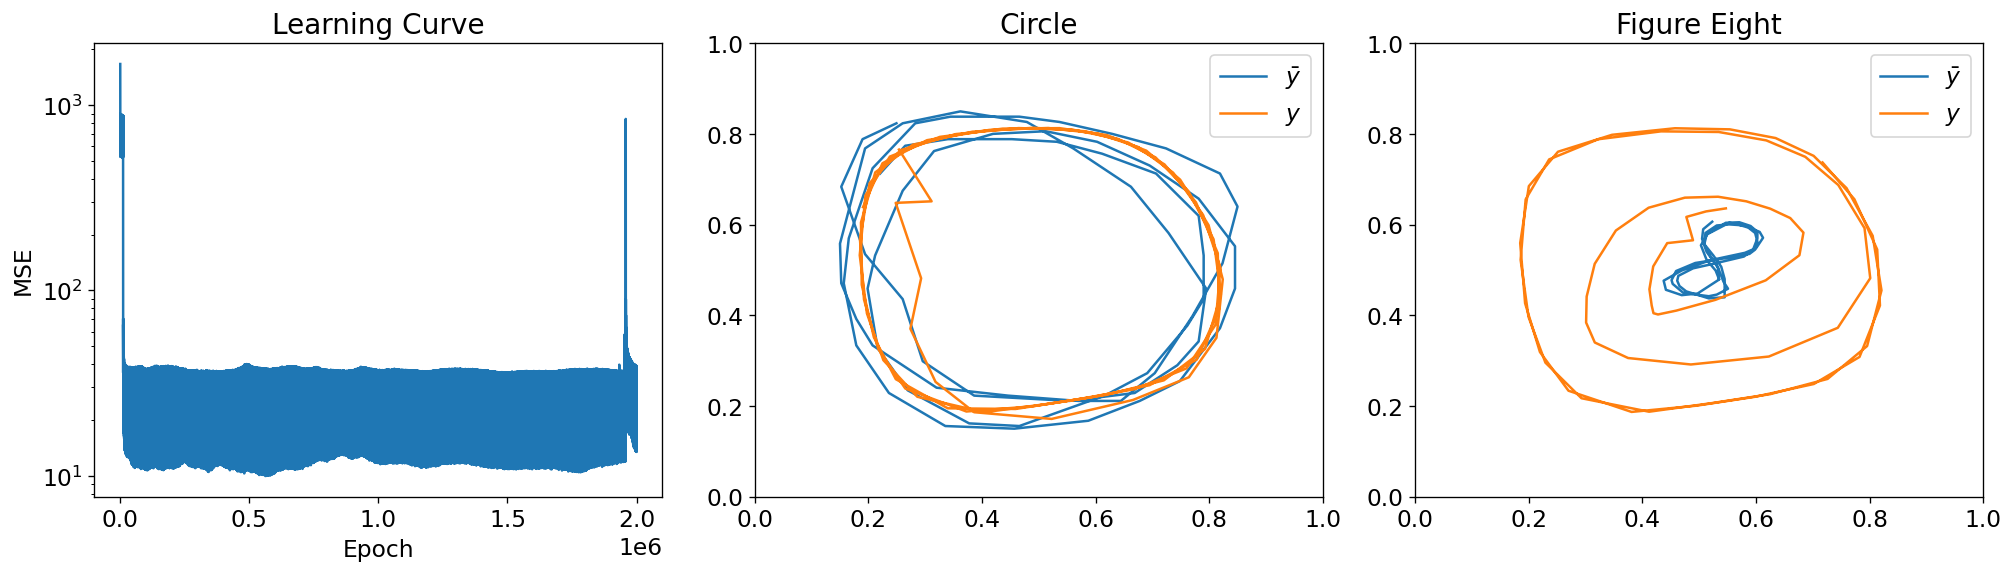

In [148]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

circleOutputArr = model.predict([circleXArr[0], circleYArr[1]], circleXArr.shape[0])

ax[1].plot(targetArr[0][1:,0], targetArr[0][1:,1], label=r'$\bar y$')
ax[1].plot(circleOutputArr[1:,0], circleOutputArr[1:,1], label=r'$y$')
ax[1].legend()
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].set_title('Circle')

ax[2] = fig.add_subplot(1, 3, 3)

feOutputArr = model.predict([feXArr[0], feYArr[1]], feXArr.shape[0])

ax[2].plot(targetArr[1][1:,0], targetArr[1][1:,1], label=r'$\bar y$')
ax[2].plot(feOutputArr[1:,0], feOutputArr[1:,1], label=r'$y$')
ax[2].legend()
ax[2].set_xlim([0,1])
ax[2].set_ylim([0,1])
ax[2].set_title('Figure Eight')

fig.tight_layout()

plt.show()

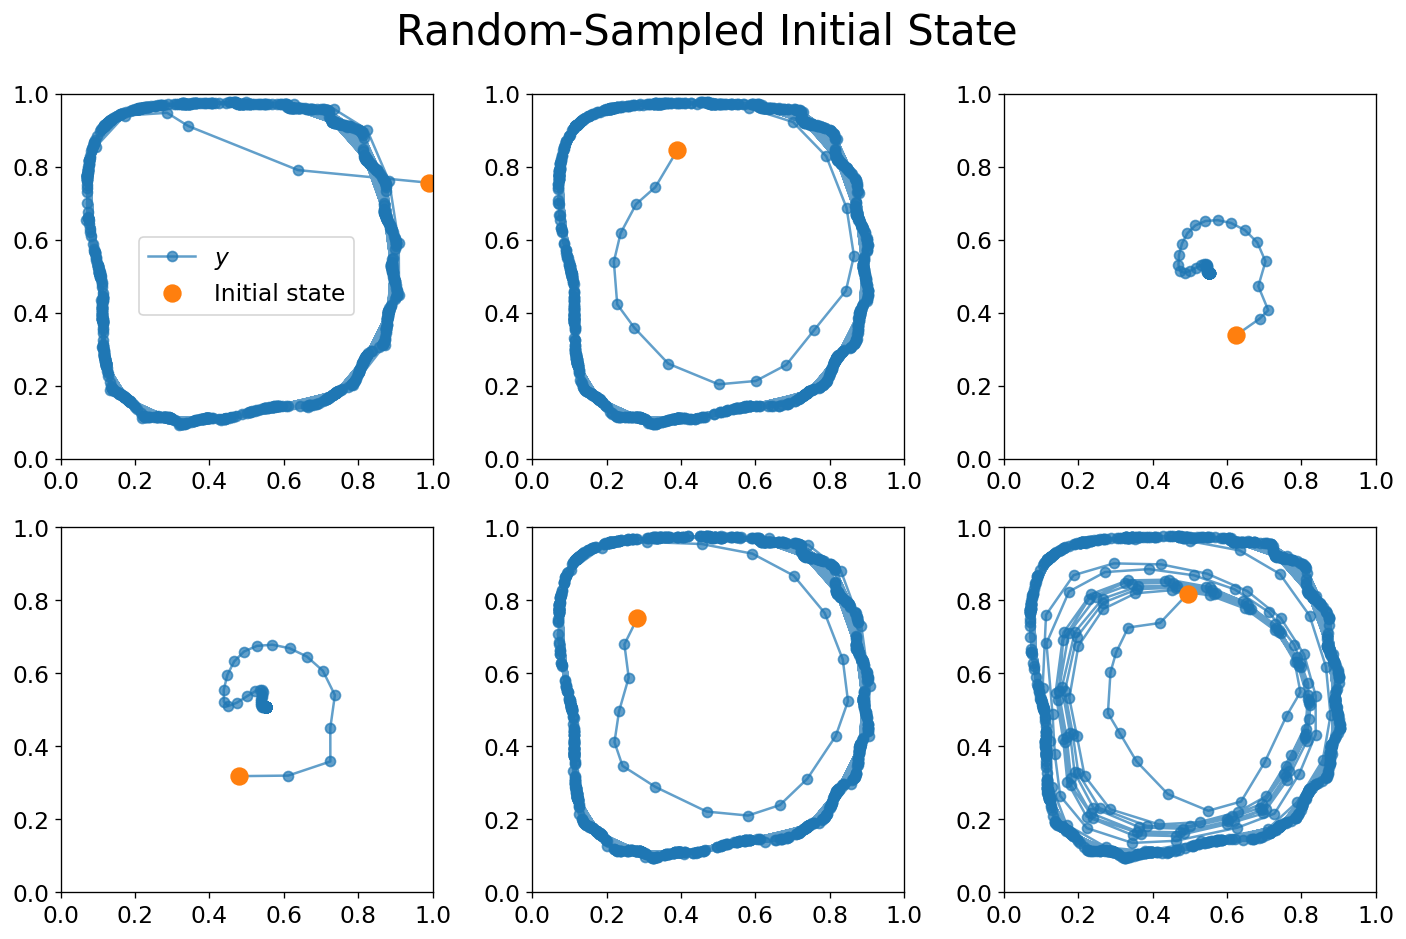

In [143]:
initialPoints = np.random.uniform(0, 1, size=(6,2))
#initialPoints = [[1, .2], [.5, .5]]

fig, ax = plt.subplots(2, len(initialPoints) // 2, figsize=(len(initialPoints)*2,8))

for i in range(len(initialPoints)):

    nSteps = 1000

    predictArr = model.predict(initialPoints[i], nSteps)
    
    ax[i//len(ax[0]),i%len(ax[0])].plot(predictArr[:,0], predictArr[:,1], '-o', alpha=.7, label='$ y $')
    ax[i//len(ax[0]),i%len(ax[0])].plot(initialPoints[i][0], initialPoints[i][1], 'o', markersize=10, label='Initial state')

    ax[i//len(ax[0]),i%len(ax[0])].set_xlim([0, 1])
    ax[i//len(ax[0]),i%len(ax[0])].set_ylim([0, 1])

ax[0,0].legend()
fig.suptitle('Random-Sampled Initial State', fontsize=25)
fig.tight_layout()
plt.show()

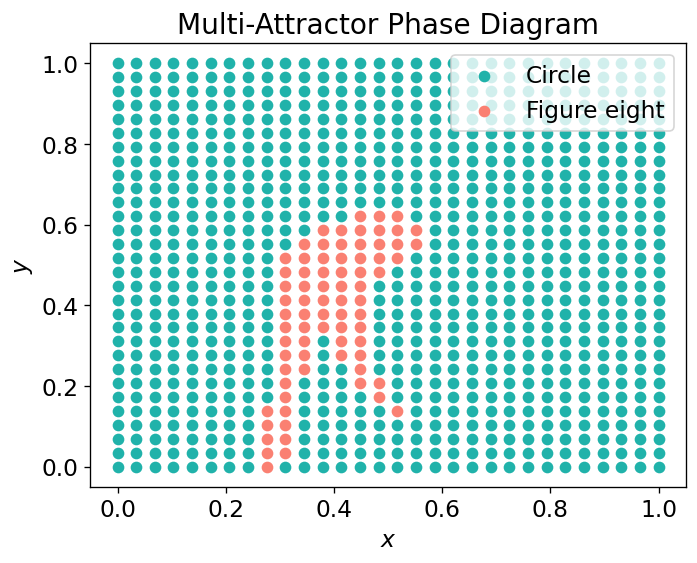

In [149]:
testXArr = np.linspace(0, 1, 30)
testYArr = np.linspace(0, 1, 30)
nSteps = 800

phaseArr = np.zeros((len(testXArr), len(testYArr)))
predictArr = np.zeros((len(testXArr), len(testYArr), nSteps+1, 2))

for i in range(len(testXArr)):
    for j in range(len(testYArr)):

        predictArr[i,j] = model.predict([testXArr[i], testYArr[j]], nSteps)
        
        # Take average of last 100
        averagePosition = np.mean(predictArr[i,j,-300:], axis=0)
        
        # If average position is around .25, .25, then it is a circle (0)
        # If average position is around .75, .75, then it is a figure eight (1)
        # Otherwise, something weird happened (2)
        
        phaseArr[i,j] = np.std(predictArr[i,j,-300:])
        
        #if np.abs(np.std(predictArr[-100:] - averagePosition) - .22) < .05:
        #   phaseArr[i,j] = 0
        #elif np.abs(np.std(predictArr[-100:] - averagePosition) - .08) < .05:
        #   phaseArr[i,j] = 1
        #else:
        #   phaseArr[i,j] = 2
            
plt.scatter(testXArr[np.where(np.abs(phaseArr - .22) < .05)[0]], testYArr[np.where(np.abs(phaseArr - .22) < .05)[1]], c='lightseagreen', label='Circle')
plt.scatter(testXArr[np.where(np.abs(phaseArr - .05) < .05)[0]], testYArr[np.where(np.abs(phaseArr - .05) < .05)[1]], c='salmon', label='Figure eight')
#plt.scatter(testXArr[np.where(phaseArr == 2)[0]], testYArr[np.where(phaseArr == 2)[1]], c='slategray', label='Non-convergent')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Multi-Attractor Phase Diagram')
plt.show()

#values, counts = np.unique(phaseArr, return_counts=True)
#print(f'Ratio of area in phase diagram: circle/total = {counts[values == 0][0] / np.sum(counts):.3}')
#print(f'Ratio of area in phase diagram: figure eight/total = {counts[values == 1][0] / np.sum(counts):.3}')

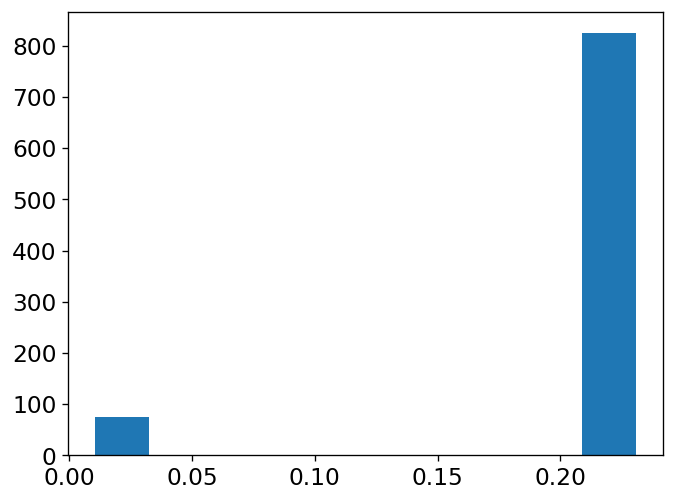

In [150]:
plt.hist(phaseArr.flatten())
plt.show()

In [151]:
colorArr = colour.Color('Red').range_to(colour.Color('Blue'), len(testXArr)*len(testYArr))
colorArr = [str(c) for c in colorArr]

#colorArr = colorArr[:-2:3] + colorArr[1:-1:3] + colorArr[2::3]

numFrames = 100
startFrames = 30
trailingPoints = 5

images = [None]*(numFrames+startFrames)

    
for j in range(len(testXArr)):
    for k in range(len(testYArr)):
        plt.plot(predictArr[j,k,0,0], predictArr[j,k,0,1], '-o', alpha=.4, c=colorArr[len(testYArr)*j+k])

canvas = plt.get_current_fig_manager().canvas
canvas.draw()

startImage = Image.frombytes('RGB', canvas.get_width_height(), 
             canvas.tostring_rgb())

plt.close()

for i in range(startFrames):#nSteps+1):
    images[i] = startImage

for i in tqdm.tqdm(range(numFrames)):#nSteps+1):
    
    for j in range(len(testXArr)):
        for k in range(len(testYArr)):
            plt.plot(predictArr[j,k,max(i-trailingPoints,0):i,0], predictArr[j,k,max(i-trailingPoints,0):i,1], '-o', alpha=.08, c=colorArr[len(testYArr)*j+k])
            plt.plot(predictArr[j,k,i,0], predictArr[j,k,i,1], '-o', alpha=.4, c=colorArr[len(testYArr)*j+k])
    
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()

    images[i+startFrames] = Image.frombytes('RGB', canvas.get_width_height(), 
                 canvas.tostring_rgb())
    #plt.show()
    plt.close()

images[0].save('images/inscribed_multi_attractor_trajectory.gif', save_all=True, append_images=images[1:], duration=.5, loop=0)

100%|█████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


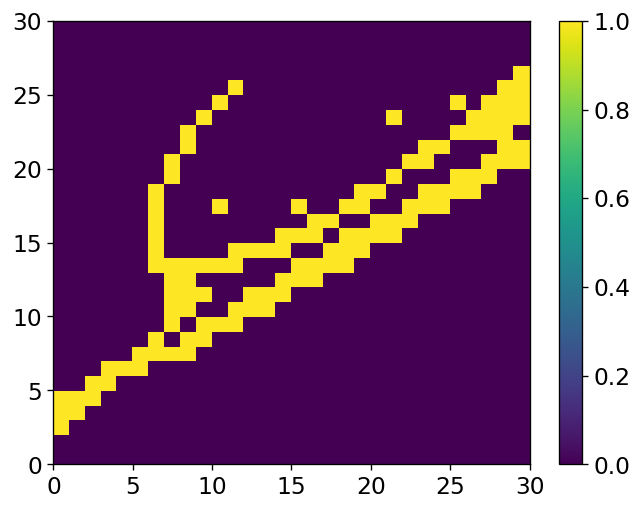

In [28]:
plt.pcolor(phaseArr)
plt.colorbar()
plt.show()